<h1>Task 3.2</h1>

In [63]:
import mlhelper as mlh #Contains classes for loading and processing the datasets.
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, \
mean_absolute_error, balanced_accuracy_score, accuracy_score, \
roc_auc_score, ConfusionMatrixDisplay, PredictionErrorDisplay, \
PrecisionRecallDisplay, RocCurveDisplay
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.inspection import DecisionBoundaryDisplay

<h2>Regression Model for GWP</h2>
In this section, we build an SVR regression model for the GWP dataset. We will:
<ul>
    <li>Split GWP into training and testing</li>
    <li>Perform Cross Validation on an SVR</li>
    <li>Perform Hyperparameter optimisation</li>
    <li>Evaluate performance</li>
</ul>

<h3>Training and Optimisation</h3>

We load the data and define a function which allows us to perform hyperparameter optimisation and evaluation on a model.

In [2]:
gwp = mlh.GWPDataset("gwp_assessment.csv")

In [20]:
#model - estimator to optimise.
#dataset - object like GWPDataset or StarDataset
#param_grid - Passed to GridSearchCV's param_grid parameter. Controls parameter space.
#scoring - A dict mapping scorer names to scorer functions. Either functions ending with _score or those returned by make_scorer.
#cv - Passed to GridSearchCV's cv parameter. Controls splitting strategy.
#refit - If scoring is not None, then specifies the name in 'scoring' which denotes the metric by which to fit the final estimator.
#train_size - Size of the training set.
#stratify - Whether to stratify the dataset when splitting.
#shuffle - Whether to shuffle the dataset before splitting.
#random_state - Seed by which to shuffle. Defaults to 1 to allow same shuffling
#when evaluating different models on same dataset.
def train(model, dataset, param_grid, scoring=None, cv=None, refit=True,
          train_size=0.8, stratify=None, shuffle=True, random_state=1):
    x_train, x_test, y_train, y_test = train_test_split(
        dataset.processed_X(), dataset.processed_Y(),
        train_size=train_size, stratify=stratify, shuffle=shuffle,
        random_state=random_state)
    
    gridsearch = GridSearchCV(model, param_grid,
                              scoring=scoring, refit=refit, cv=cv)
    gridsearch.fit(x_train, y_train)
    
    best_model=gridsearch.best_estimator_
    
    #Evaluate giving scoring metrics on test data.
    test_scores = {}
    if(not(scoring is None)):
        for name, scorer in scoring.items():
            test_scores.update({name: scorer(best_model, x_test, y_test)})
    else:
        test_scores = {'score' : model.score(x_test, y_test)}
    return {"best_model": best_model,
            "grid_search": gridsearch,
            "test_scores": test_scores,
            "dataset": (x_train, x_test, y_train, y_test)}
    
    
    

We perform grid search cross validation for the SVR. Hyperparameters and their ranges were chosen by consulting sklearn docs. We search the following parameter space and use the following scores:

In [21]:
svr_param_space = [
  {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
  {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
 ]

Originally, we tried searching over the space as commented out below, but it took too long so we reduced it.

In [22]:
#svr_param_space = [
#  {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
#  {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
#  {'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'degree': [3, 10, 30], 
#   'gamma': [0.001, 0.0001], 'coef0': [0, 1, 10]},
#  {'kernel': ['sigmoid'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
#  'coef0': [0, 1, 10]}
# ]

We use the following metrics. All standard scores for evaluating regression models.

In [23]:
svr_scores = {
    "r2_score": make_scorer(r2_score),
    "mse_score": make_scorer(mean_squared_error, greater_is_better=False),
    "mae_score": make_scorer(mean_absolute_error, greater_is_better=False)
}

Now we run grid search for an SVR across this parameter space. We fit our final model using r2.

In [24]:
svr_results = train(SVR(), gwp, svr_param_space, svr_scores, 5, refit="r2_score")

<h3>Evaluation</h3>

Through the process of grid search, we find our best SVR has the following hyperparameters:

In [25]:
svr_results["grid_search"].best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

With the test scores:

In [26]:
svr_results["test_scores"]

{'r2_score': 0.16258242333646944,
 'mse_score': -0.026822311550866517,
 'mae_score': -0.1183129921620627}

To get a sense of the power of our SVR, let's first see how a dummy regressor performs. In this case, the dummy regressor always predicts the mean.

In [28]:
gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test = svr_results["dataset"]

dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(gwp_x_train, gwp_y_train)
print("dummy r2 score:", dummy_regressor.score(gwp_x_test, gwp_y_test))

dummy r2 score: -3.2232634892714884e-05


Clearly, our regressor is better than the dummy regressor, but the r2 score is nonetheless quite low.

<h4>Visualisations</h4>
Let's try visualising its performance.

<h5>Prediction Error Display</h5>

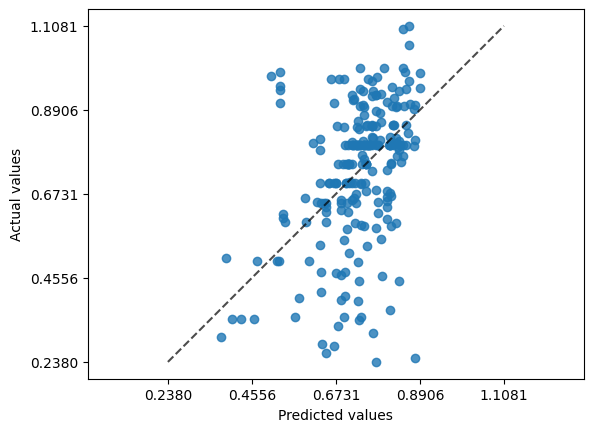

In [29]:
PredictionErrorDisplay(y_true=gwp_y_test, 
                       y_pred=svr_results["best_model"].predict(gwp_x_test)
                      ).plot(kind="actual_vs_predicted")

SVR has been unsuccessful at aligning its predictions with the distribution of the actual values. It tends to overpredict smaller values and underpredict larger values. It seems to do best with values between 0.6 and 0.9.

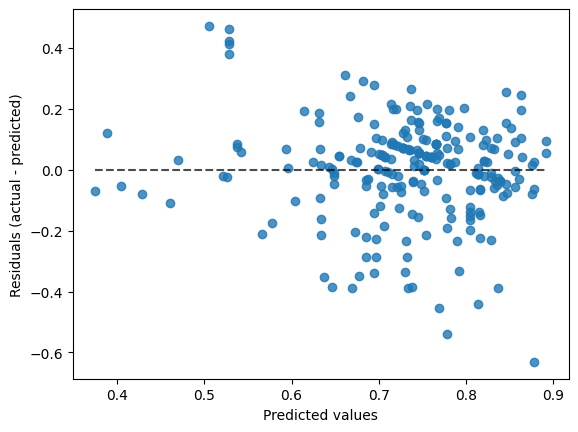

In [35]:
PredictionErrorDisplay(y_true=gwp_y_test, 
                       y_pred=svr_results["best_model"].predict(gwp_x_test)
                      ).plot(kind="residual_vs_predicted")

The SVR has managed to minimise the residuals of the majority of the points but the residuals are substantial for those many points it wasn't able to correctly predict. 

<h2>Classification Model for Star Dataset</h2>
In this section we build an SVC to classify the star dataset. We will do the following:
<ul>
    <li>Split Star Dataset into training and testing</li>
    <li>Perform Cross Validation on an SVC</li>
    <li>Perform Hyperparameter optimisation</li>
    <li>Evaluate performance</li>
</ul>

<h3>Training and Optimisation</h3>

In [38]:
star = mlh.StarDataset("star_assessment.csv")

We search the following parameter space which was decided upon by consulting the scikitlearn docs for appropriate hyperparameter adjustments.

In [39]:
svc_param_space = [
  {'kernel': ['linear'], 'C': [1, 100]},
 ]

Originally, we tried searching over the space as commented out below, but it took too long so we reduced it.

In [40]:
#svc_param_space = [
#  {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
#  {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
# ]

We use the following metrics which are standard classification metrics. We look at balanced accuracy due to the class imbalance in the dataset:

In [42]:
svc_scores = {
    "accuracy_score": make_scorer(accuracy_score),
    "balanced_accuracy_score": make_scorer(balanced_accuracy_score),
}

We stratify the training samples to improve performance. 
WARNING: Takes a while to run. Around 10 minutes on the machine which this was written.

In [43]:
svc_results = train(SVC(), star, svc_param_space, svc_scores, 5, refit="accuracy_score", stratify=star.processed_Y())

<h3>Evaluation</h3>

Through the process of grid search, we find our best SVC has the following hyperparameters:

In [44]:
svc_results["grid_search"].best_params_

{'C': 100, 'kernel': 'linear'}

With test scores:

In [45]:
svc_results["test_scores"]

{'accuracy_score': 0.9595, 'balanced_accuracy_score': 0.9483356402401286}

To get a sense of the power of our SVC, let's first see how a dummy classifier performs. In this case, the dummy classifier chooses a class from a uniform distribution.

In [57]:
star_x_train, star_x_test, star_y_train, star_y_test = svc_results["dataset"]

dummy_classifier = DummyClassifier(strategy='uniform')
dummy_classifier.fit(star_x_train, star_y_train)
print("accuracy score:",
      dummy_classifier.score(star_x_test, star_y_test))

accuracy score: 0.33065


Our svc classifier performs significantly better.

<h4>Visualisations</h4>

In [58]:
star_class_labels=["galaxy", "quasar", "star"]

<h5>Confusion Matrix</h5>

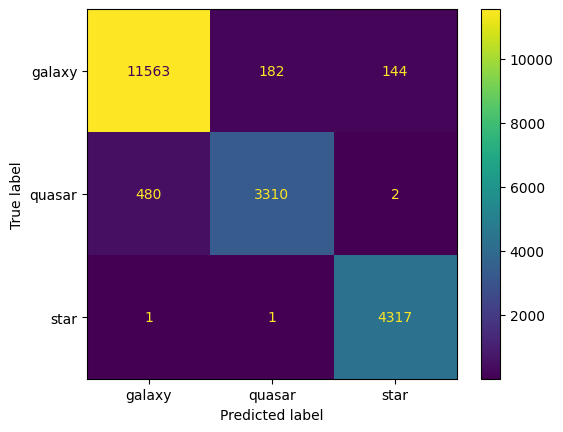

In [59]:
ConfusionMatrixDisplay.from_estimator(svc_results["best_model"],
                                      star_x_test, star_y_test,
                                     display_labels=star_class_labels)

The classifier is best at predicting stars and galaxies which isn't surprising given they're the most well represented classes in the dataset.

We add the function model to the mlhelper module for future use.

<h2>Markdown Question</h2>

Despite its name, linear regression is suited to both regression and classification tasks. It is possible to use multi-response linear regression to classify the star dataset. Since the problem has three classes, it is possible to solve with with three binary linear regression classifiers where each binary classifier outputs a value indicating the likelihood that it belongs to its class. From these three binary classifiers, the one with the highest output is chosen and its class is the output of the prediction. While it is certainly an option, its efficacy in solving the problem is not clear without actually fitting and evaluating a real model. 